# Comparison of MS partitions and NUTS at baseline

We compare MS partitions with NUTS partitions of the UK and first establish correspondences between MS and NUTS on three levels of hierarchy, fine, medium and coarse. Then we evalute the partitions with the Coverage and Nodal Containment measures.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pickle
import scipy.sparse as sp
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
plt.rcParams.update({'font.size': 20})

In [3]:
import sys
from pathlib import Path
path = str(Path.cwd().parents[0])

module_path = str(Path.cwd().parents[0] / "src")
if module_path not in sys.path:
    sys.path.append(module_path)

from network_analysis import compute_indicator_matrix, compute_coverage, compute_coverage_community, compute_nodal_containment
from utils import R2_score

root_figure = path+"/figures/"
root_map = path+'/data/geo_shapefiles/NUTS_Level_3__January_2018__Boundaries-shp/NUTS_Level_3__January_2018__Boundaries.shp'
root_processed = path+"/data/processed/"
root_networks = path+"/data/processed/networks/"
root_results = path+"/results/"

## Import baseline network

In [4]:
# load baseline network
A_LSCC = sp.load_npz(root_networks+"baseline_network.npz")
lscc = nx.from_scipy_sparse_matrix(A_LSCC,create_using = nx.DiGraph)

# load node quadkeys
lscc_nodes = []
with open(root_networks+'node_quadkeys.txt', 'r') as filehandle:
    for line in filehandle:
        curr_quadkey = line[:-1]
        lscc_nodes.append(curr_quadkey)
n_nodes = len(lscc_nodes)

## Obtain NUTS partitions

In [5]:
# Load NUTS3 data
root_NUTS3 = root_processed+'MOVEMENT_QUADKEY_NUTS3_GB.csv'
df_NUTS = pd.read_csv(root_NUTS3)
print('Shape of NUTS3 data:', df_NUTS.shape)

# Delete _ in front of quadkeys
quadkeys = [df_NUTS['quadkey'][i][1:] for i in range(df_NUTS.shape[0])]

# Get NUTS3 region names
NUTS3 = df_NUTS.columns.values.tolist()[1:]

# Get NUTS2 regions
to_NUTS2 = {NUTS3[i] : NUTS3[i][:4] for i in range(len(NUTS3))}
NUTS2_index = {list(to_NUTS2.values())[i] : i for i in range(len(to_NUTS2))}

# Get NUTS1 regions
to_NUTS1 = {NUTS3[i] : NUTS3[i][:3] for i in range(len(NUTS3))}
NUTS1_index = {list(to_NUTS1.values())[i] : i for i in range(len(to_NUTS1))}

# Compute for each quadkey NUTS3 region by max vote 
X = np.asarray(df_NUTS.iloc[:,1:])
max_rule = np.argmax(X,axis = 1)
print('The max is obtained in average with:',
      np.around(np.max(X,axis = 1).mean(),2) )

# Create dictionary from quadkeys to NUTS3 region id's
quadkey_NUTS3 = {quadkeys[i] : max_rule[i] for i in range(df_NUTS.shape[0])}

# Generate NUTS3 Id's for LSCC nodes
NUTS3_id = np.asarray([quadkey_NUTS3[lscc_nodes[i]] for i in range(n_nodes)])
print('NUTS3 communities in LSCC:', len(set(NUTS3_id)))

# Generate NUTS2 Id's
NUTS2_id = np.asarray([ NUTS2_index[to_NUTS2[NUTS3[NUTS3_id[i]]]] for i in range(n_nodes)])
print('NUTS2 communities in LSCC:', len(set(NUTS2_id)))

# Generate NUTS1 Id's
NUTS1_id = np.asarray([ NUTS1_index[to_NUTS1[NUTS3[NUTS3_id[i]]]] for i in range(n_nodes)])
print('NUTS1 communities in LSCC:', len(set(NUTS1_id)))

Shape of NUTS3 data: (3125, 180)
The max is obtained in average with: 0.92
NUTS3 communities in LSCC: 170
NUTS2 communities in LSCC: 42
NUTS1 communities in LSCC: 12


In [6]:
NUTS_partitions = []
node_keys = lscc_nodes

for labels in [NUTS3_id,NUTS2_id,NUTS1_id]:
    k = len(set(labels))
    partition = []
    for i in set(labels):
        c = np.argwhere(labels == i).flatten()
        c_set = set(node_keys[j] for j in c)
        partition.append(c_set)
    NUTS_partitions.append(partition)

NUTS_partitions = np.asarray(NUTS_partitions)

In [7]:
NUTS_partitions = []

for node_id in [NUTS3_id,NUTS2_id,NUTS1_id]:
    H = compute_indicator_matrix(node_id)
    # delete empty columns
    H = H[:, np.sum(H, axis=0) > 0]
    NUTS_partitions.append(H)

In [8]:
# statistics for NUTS
partition_names = []
rank_partitions = []
max_c = []
Q1_c = []
Q2_c = []
Q3_c = []
min_c = []

for i in range(3):

    level = "NUTS {}".format(i+1)
    partition_names.append(level)
    partition = NUTS_partitions[i]
    n_communities = np.linalg.matrix_rank(partition)
    rank_partitions.append(n_communities)
    community_sizes = np.sum(partition, axis=0)
    max_c.append(int(np.max(community_sizes)))
    Q1_c.append(int(np.percentile(community_sizes, q =25)))
    Q2_c.append(int(np.percentile(community_sizes, q =50)))
    Q3_c.append(int(np.percentile(community_sizes, q =75)))
    min_c.append(int(np.min(community_sizes)))
    
community_stats = pd.DataFrame({'Level' : partition_names, 'n_communities' : rank_partitions, 'min_size' : min_c,
                                'Q1':Q1_c, 'Q2' : Q2_c, 'Q3' : Q3_c, 'max_size' : max_c})

In [9]:
partition = NUTS_partitions[0]

In [10]:
community_stats

,Level,n_communities,min_size,Q1,Q2,Q3,max_size
0,NUTS 1,170,1,4,13,27,102
1,NUTS 2,42,1,40,72,102,238
2,NUTS 3,12,44,230,254,324,422


## Comparison of MS and NUTS partitions via NVI

In [11]:
# Load data (deserialize)
with open(root_results+'MS_results.pkl', 'rb') as handle:
    all_results = pickle.load(handle)

# Get times
times = all_results['times']
min_time = all_results['run_params']['min_time']
max_time = all_results['run_params']['max_time']
n_time = all_results['run_params']['n_time']
log_times = np.linspace(min_time,max_time,n_time)

# Get information about communities
community_id = np.asarray(all_results['community_id'])
n_communities  = np.asarray(all_results['number_of_communities'])
n_times = len(n_communities)

In [12]:
community_id_ranked = community_id.copy()

for time in range(n_times):
    # Compute sizes of each community
    labels_graph_counts = np.histogram(community_id[time],bins=np.arange(0,n_communities[time]+1)) [0]
    # Get class indices sorted according to size
    community_ranked = np.argsort(-labels_graph_counts)
    # Create dictionary that describes map from old labels to new labels
    rank = {community_ranked[k] : k for k in range(0,n_communities[time])}
    # Apply permutation to labels
    labels_community = community_id[time].copy()
    for i in range (0,len(labels_community)):
        labels_community[i] = rank[labels_community[i]]
    
    community_id_ranked[time] = labels_community

In [13]:
from sklearn import metrics

In [14]:
def entropy(labels):
    """Calculates the entropy for a labeling.
    Parameters
    ----------
    labels : int array, shape = [n_samples]
        The labels
    Notes
    -----
    The logarithm used is the natural logarithm (base-e).
    """
    if len(labels) == 0:
        return 1.0
    label_idx = np.unique(labels, return_inverse=True)[1]
    pi = np.bincount(label_idx).astype(np.float64)
    pi = pi[pi > 0]
    pi_sum = np.sum(pi)
    # log(a / b) should be calculated as log(a) - log(b) for
    # possible loss of precision
    return -np.sum((pi / pi_sum) * (np.log(pi) - np.log(pi_sum)))

def variation_of_information(x,y, normalised = True):
    Ex = entropy(x)
    Ey = entropy(y)
    I = metrics.mutual_info_score(x,y)
    
    if normalised:
        return  (Ex + Ey - 2*I) / (Ex + Ey - I)
    else: 
        return Ex + Ey - 2*I

In [15]:
nvi_NUTS1 = []
nvi_NUTS2 = []
nvi_NUTS3 = []


for time in range(n_time):
    nvi_NUTS1.append(variation_of_information(community_id_ranked[time],NUTS1_id))
    nvi_NUTS2.append(variation_of_information(community_id_ranked[time],NUTS2_id))
    nvi_NUTS3.append(variation_of_information(community_id_ranked[time],NUTS3_id))

nvi_NUTS1 = np.asarray(nvi_NUTS1)
nvi_NUTS2 = np.asarray(nvi_NUTS2)
nvi_NUTS3 = np.asarray(nvi_NUTS3)

In [16]:
# Compute optimal times for NVI
nvi_t_NUTS1 = log_times[np.argmin(nvi_NUTS1)]
nvi_NUTS1_min = np.min(nvi_NUTS1)
print('Optimal Markov time for NUTS1:', np.around(nvi_t_NUTS1,2), 'with NVI', 
      np.around(nvi_NUTS1_min,2))
nvi_t_NUTS2 = log_times[np.argmin(nvi_NUTS2)]
nvi_NUTS2_min = np.min(nvi_NUTS2)
print('Optimal Markov time for NUTS2:', np.around(nvi_t_NUTS2,2), 'with NVI', 
      np.around(nvi_NUTS2_min,2))
nvi_t_NUTS3 = log_times[np.argmin(nvi_NUTS3)]
nvi_NUTS3_min = np.min(nvi_NUTS3)
print('Optimal Markov time for NUTS3:', np.around(nvi_t_NUTS3,2), 'with NVI', 
      np.around(nvi_NUTS3_min,2))

Optimal Markov time for NUTS1: 0.88 with NVI 0.41
Optimal Markov time for NUTS2: -0.34 with NVI 0.33
Optimal Markov time for NUTS3: -1.63 with NVI 0.27


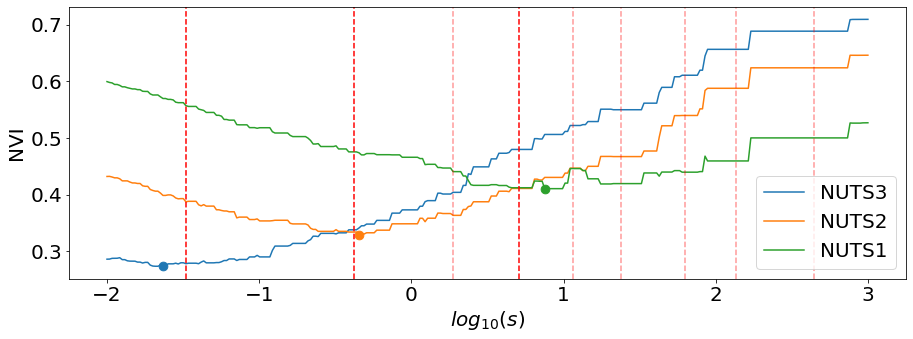

In [17]:
robust_scales = all_results["selected_partitions"]

# Plot
fig, ax = plt.subplots(1,figsize =(15,5))

ax.plot(log_times,nvi_NUTS3, label = 'NUTS3')
ax.plot(log_times,nvi_NUTS2, label = 'NUTS2')
ax.plot(log_times,nvi_NUTS1, label = 'NUTS1')

ax.scatter(nvi_t_NUTS3,nvi_NUTS3_min,marker='.',s=300)
ax.scatter(nvi_t_NUTS2,nvi_NUTS2_min,marker='.',s=300)
ax.scatter(nvi_t_NUTS1,nvi_NUTS1_min,marker='.',s=300)

for i in robust_scales:
    if i in [robust_scales[0],robust_scales[1],robust_scales[3]]:
        ax.axvline(x = log_times[i], ls="--", color = 'red')
    else:
        ax.axvline(x = log_times[i], ls="--", color = 'red', alpha = 0.4)



ax.set(xlabel = r"$log_{10}(s)$",ylabel = 'NVI') #,sitle='Similarity between Markov Stability partitions and NUTS regions')
        #yticks = [0.3,0.5,0.7] ) 
ax.legend(loc=4)
plt.show()

fig.savefig(root_figure +'MS_NUTS_matching.pdf', dpi=fig.dpi,bbox_inches='tight')

In [18]:
# select the three MS partitions most similar to NUTS
MS0_id = np.asarray(all_results['community_id'][robust_scales[0]])
MS1_id = np.asarray(all_results['community_id'][robust_scales[1]])
MS3_id = np.asarray(all_results['community_id'][robust_scales[3]])

MS_partitions = []

for node_id in [MS0_id,MS1_id,MS3_id]:
    H = compute_indicator_matrix(node_id)
    MS_partitions.append(H)

## Comparison of Coverage of partitions

In [19]:
coverage_NUTS = 100*np.array([compute_coverage(lscc,NUTS_partitions[0]),compute_coverage(lscc,NUTS_partitions[1]),compute_coverage(lscc,NUTS_partitions[2])])
coverage_MS = 100*np.array([compute_coverage(lscc,MS_partitions[0]),compute_coverage(lscc,MS_partitions[1]),compute_coverage(lscc,MS_partitions[2])])

In [20]:
print("Average Coverage of NUTS3:", np.around(coverage_NUTS[0],1))
print("Average Coverage of NUTS2:", np.around(coverage_NUTS[1],1))
print("Average Coverage of NUTS1:", np.around(coverage_NUTS[2],1))

Average Coverage of NUTS3: 90.1
Average Coverage of NUTS2: 95.2
Average Coverage of NUTS1: 98.9


In [21]:
print("Average Coverage of MS1:", np.around(coverage_MS[0],1))
print("Average Coverage of MS2:", np.around(coverage_MS[1],1))
print("Average Coverage of MS4:", np.around(coverage_MS[2],1))

Average Coverage of MS1: 92.1
Average Coverage of MS2: 98.4
Average Coverage of MS4: 99.7


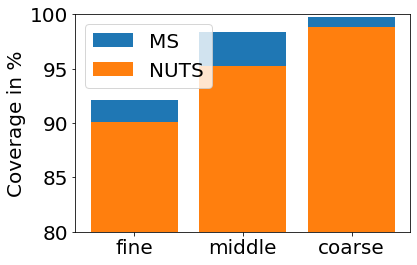

In [22]:
fig, ax = plt.subplots(1)
ax.bar(range(3),coverage_MS,label='MS')
ax.bar(range(3),coverage_NUTS,label='NUTS')
ax.set(xticks=range(3),xticklabels=['fine','middle','coarse'],ylim=(80,100),ylabel='Coverage in %')
ax.legend()
plt.show()

## Comparison of average Nodal Containment

In [23]:
# Compute Containment
NC_NUTS3 = compute_nodal_containment(lscc,NUTS3_id)
NC_NUTS2 = compute_nodal_containment(lscc,NUTS2_id)
NC_NUTS1 = compute_nodal_containment(lscc,NUTS1_id)
NC_MS0 = compute_nodal_containment(lscc,MS0_id)
NC_MS1 = compute_nodal_containment(lscc,MS1_id)
NC_MS3 = compute_nodal_containment(lscc,MS3_id)

In [24]:
print("Average NC of NUTS3:", np.around(100*np.mean(NC_NUTS3),1))
print("Average NC of NUTS2:", np.around(100*np.mean(NC_NUTS2),1))
print("Average NC of NUTS1:", np.around(100*np.mean(NC_NUTS1),1))

Average NC of NUTS3: 72.8
Average NC of NUTS2: 88.3
Average NC of NUTS1: 95.8


In [25]:
print("Average NC of MS1:", np.around(100*np.mean(NC_MS0),1))
print("Average NC of MS2:", np.around(100*np.mean(NC_MS1),1))
print("Average NC of MS4:", np.around(100*np.mean(NC_MS3),1))

Average NC of MS1: 86.6
Average NC of MS2: 95.5
Average NC of MS4: 98.1


## Summary Box Plots for Coverage on community level and Nodal Containment

In [26]:
# Compute Coverage on community level
coverage_k_NUTS3 = compute_coverage_community(lscc,NUTS_partitions[0])
coverage_k_NUTS2 = compute_coverage_community(lscc,NUTS_partitions[1])
coverage_k_NUTS1 = compute_coverage_community(lscc,NUTS_partitions[2])
coverage_k_MS0 = compute_coverage_community(lscc,MS_partitions[0])
coverage_k_MS1 = compute_coverage_community(lscc,MS_partitions[1])
coverage_k_MS3 = compute_coverage_community(lscc,MS_partitions[2])

In [27]:
Coverage = pd.DataFrame.from_dict({'NUTS3' : coverage_k_NUTS3,'MS0':coverage_k_MS0,'NUTS2' : coverage_k_NUTS2,'MS1':coverage_k_MS1,'NUTS1' : coverage_k_NUTS1,'MS3':coverage_k_MS3,}, orient='index')
Coverage = Coverage.transpose()

NC = pd.DataFrame.from_dict({'NUTS3' : NC_NUTS3,'MS0':NC_MS0,'NUTS2' : NC_NUTS2,'MS1':NC_MS1,'NUTS1' : NC_NUTS1,'MS3':NC_MS3,}, orient='index')
NC = NC.transpose()

In [28]:
from matplotlib.patches import Patch

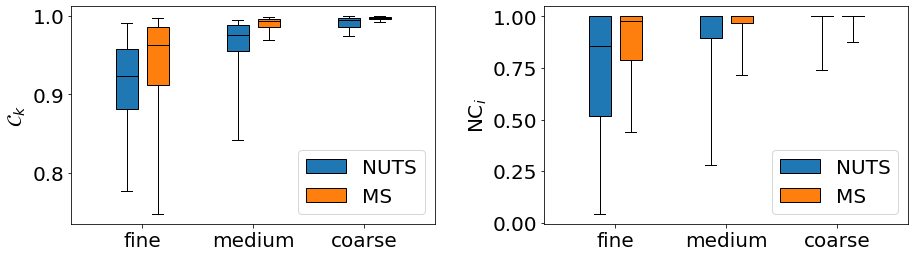

In [29]:
fig = plt.figure(figsize=(15,4))
fig.subplots_adjust(wspace=0.3)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

x = np.arange(3)
offset=0.14
xticklabels = ['fine','medium','coarse']

legend_elements = [Patch(facecolor='tab:blue', edgecolor='black',label='NUTS'),Patch(facecolor='tab:orange', edgecolor='black',label='MS')]


box_param = dict(whis=(5, 95), widths=0.2, patch_artist=True,
                 flierprops=dict(marker='.', markeredgecolor='black',
                 fillstyle=None), medianprops=dict(color='black'),
                 meanprops=dict(marker='.',ms=15,mfc='red', markeredgecolor='black',
                 fillstyle=None))

ax1.boxplot(np.asarray([coverage_k_NUTS3,coverage_k_NUTS2,coverage_k_NUTS1]),positions=x-offset,notch=False,boxprops=dict(facecolor='tab:blue'),showfliers=False, showmeans=False,**box_param)
ax1.boxplot(np.asarray([coverage_k_MS0,coverage_k_MS1,coverage_k_MS3]),positions=x+offset,notch=False,boxprops=dict(facecolor='tab:orange'),showfliers=False, showmeans=False,**box_param)
ax1.set(xticks=x,xticklabels=xticklabels,ylabel=r'$\mathcal{C}_k$')
ax1.legend(handles=legend_elements)

ax2.boxplot(np.asarray([NC_NUTS3,NC_NUTS2,NC_NUTS1]).transpose(),positions=x-offset,notch=False,boxprops=dict(facecolor='tab:blue'),showfliers=False, showmeans=False, **box_param)
ax2.boxplot(np.asarray([NC_MS0,NC_MS1,NC_MS3]).transpose(),positions=x+offset,notch=False,boxprops=dict(facecolor='tab:orange'),showfliers=False,showmeans=False, **box_param)
ax2.set(xticks=x,xticklabels=xticklabels,ylabel=r'NC$_i$')
ax2.legend(handles=legend_elements)

plt.show()

##path'/home/tc/OneDrive/Research Projects/Multiscale mobility patterns and the restriction of human mobility under lockdown/Figures/Figure 4/'

fig.savefig(root_figure+'comparison_boxplots_coverage_NC.pdf', dpi=fig.dpi,bbox_inches='tight')

## Statistical tests

In [30]:
# apply Mann-Whitney U test
from scipy.stats import mannwhitneyu

print('Fine - NUTS3/MS0')
U, p_f_coverage = mannwhitneyu(coverage_k_NUTS3,coverage_k_MS0)
print('Coverage: Mann-Whitney U test rejects null hypothesis with p-value: ', p_f_coverage)
U, p_f_nc = mannwhitneyu(NC_NUTS3,NC_MS0)
print('NC: Mann-Whitney U test rejects null hypothesis with p-value: ', p_f_nc)


print('\nMedium - NUTS2/MS1')
U, p_m_coverage = mannwhitneyu(coverage_k_NUTS2,coverage_k_MS1)
print('Coverage: Mann-Whitney U test rejects null hypothesis with p-value: ', p_m_coverage)
U, p_m_nc = mannwhitneyu(NC_NUTS2,NC_MS1)
print('NC: Mann-Whitney U test rejects null hypothesis with p-value: ', p_m_nc)

print('\nCoarse - NUTS1/MS3')
U, p_c_coverage = mannwhitneyu(coverage_k_NUTS1,coverage_k_MS3)
print('Coverage: Mann-Whitney U test rejects null hypothesis with p-value: ', p_c_coverage)
U, p_c_nc = mannwhitneyu(NC_NUTS1,NC_MS3)
print('NC: Mann-Whitney U test rejects null hypothesis with p-value: ', p_c_nc)

Fine - NUTS3/MS0
Coverage: Mann-Whitney U test rejects null hypothesis with p-value:  1.715334709894178e-07
NC: Mann-Whitney U test rejects null hypothesis with p-value:  4.1806453432159544e-54

Medium - NUTS2/MS1
Coverage: Mann-Whitney U test rejects null hypothesis with p-value:  3.119699311248298e-07
NC: Mann-Whitney U test rejects null hypothesis with p-value:  1.1754134204188366e-16

Coarse - NUTS1/MS3
Coverage: Mann-Whitney U test rejects null hypothesis with p-value:  0.061682841920716505
NC: Mann-Whitney U test rejects null hypothesis with p-value:  0.00024452779026533475


## Nodal containment - histograms

In [31]:
# Compute nodal differences of containment for MS0 vs NUTS3, MS1 vs NUTS2 and MS3 vs NUTS1
diff_fine = (compute_nodal_containment(lscc,MS0_id)-compute_nodal_containment(lscc,NUTS3_id))
diff_middle = (compute_nodal_containment(lscc,MS1_id)-compute_nodal_containment(lscc,NUTS2_id))
diff_coarse = (compute_nodal_containment(lscc,MS3_id)-compute_nodal_containment(lscc,NUTS1_id))

In [32]:
print('Differences of containment for MS0 vs NUTS3:')
print('Mean: ',np.around(diff_fine.mean(),3))
print('Std: ',np.around(diff_fine.std(),3))
print('\n')
print('Differences of containment for MS1 vs NUTS2:')
print('Mean: ',np.around(diff_middle.mean(),3))
print('Std: ',np.around(diff_middle.std(),3))
print('\n')
print('Differences of containment for MS3 vs NUTS1:')
print('Mean: ',np.around(diff_coarse.mean(),3))
print('Std: ',np.around(diff_coarse.std(),3))

Differences of containment for MS0 vs NUTS3:
Mean:  0.138
Std:  0.298


Differences of containment for MS1 vs NUTS2:
Mean:  0.072
Std:  0.228


Differences of containment for MS3 vs NUTS1:
Mean:  0.023
Std:  0.157


In [33]:
import matplotlib as mpl

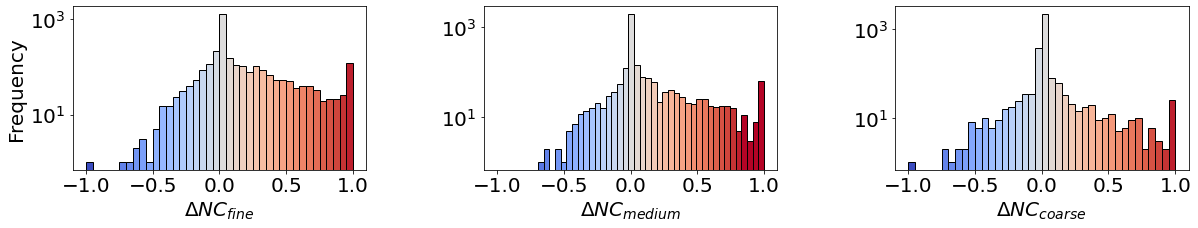

In [34]:
fig = plt.figure(figsize=(20,3))
fig.subplots_adjust(wspace=0.4)
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

n_bins = 40
cm = plt.cm.coolwarm

n, bins, patches = ax1.hist(diff_fine, bins=n_bins, edgecolor='black')
ax1.set(xticks=[-1,-0.5,0,0.5,1],ylabel='Frequency',xlabel=r'$\Delta NC_{fine}$',yscale='log',xlim=(-1.1,1.1))
for i, p in enumerate(patches):
    plt.setp(p, 'facecolor', cm(i/n_bins))

n, bins, patches = ax2.hist(diff_middle, bins=n_bins, edgecolor='black')
ax2.set(xticks=[-1,-0.5,0,0.5,1],#ylabel='Frequency',
xlabel=r'$\Delta NC_{medium}$',yscale='log',xlim=(-1.1,1.1))
for i, p in enumerate(patches):
    plt.setp(p, 'facecolor', cm((i+4)/n_bins))

n, bins, patches = ax3.hist(diff_coarse, bins=n_bins, edgecolor='black')
ax3.set(xticks=[-1,-0.5,0,0.5,1],#ylabel='Frequency',
xlabel=r'$\Delta NC_{coarse}$',yscale='log',xlim=(-1.1,1.1))
for i, p in enumerate(patches):
    plt.setp(p, 'facecolor', cm(i/n_bins))


plt.show()

#path'/home/tc/OneDrive/Research Projects/Multiscale mobility patterns and the restriction of human mobility under lockdown/Figures/Figure 5/'

fig.savefig(root_figure+'containment_hist.pdf', dpi=fig.dpi,bbox_inches='tight')



## Nodal Containment - maps

In [35]:
import geopandas as gpd
import mercantile
from shapely.geometry import shape

In [36]:
# Get quadkeys from lscc
quadkeys = lscc_nodes
polys = []

# Iterate over all quadkeys to create corresponding polygons
for quadkey in quadkeys:
    tile = mercantile.feature(mercantile.quadkey_to_tile(quadkey), projected = 'web mercator')
    polys.append(tile.get('geometry'))
geom = [shape(i) for i in polys]
gdf = gpd.GeoDataFrame({'geometry':geom, 'quadkey':quadkeys}, crs = "EPSG:4326")
gdf = gdf.to_crs("EPSG:3395")

In [37]:
gdf['diff_fine']=diff_fine
gdf['diff_middle']=diff_middle
gdf['diff_coarse']=diff_coarse

In [38]:
# Import NUTS shape files
map_gdf = gpd.read_file(root_map)
map_gdf = map_gdf.to_crs("EPSG:3395")

# remove Scotish islands
map_gdf=map_gdf[~map_gdf['nuts318cd'].isin(['UKM65', 'UKM66'])]
map_gdf.reset_index(drop=True,inplace=True)

# Get NUTS3 
cols = [0,2,3,4,5,6,7,8]
gdf_NUTS3 = map_gdf.drop(map_gdf.columns[cols],axis=1)
gdf_NUTS3.rename(columns={'nuts318cd': 'nuts'}, inplace=True)

gdf_NUTS3['DUMMY'] = 1
gdf_bndr = gdf_NUTS3.dissolve(by = 'DUMMY')


# Get NUTS2
gdf_NUTS2 = gdf_NUTS3.copy()
gdf_NUTS2['nuts'] = [gdf_NUTS2['nuts'][i][:4] for i in range((len(gdf_NUTS3)))]
gdf_NUTS2 = gdf_NUTS2.dissolve(by='nuts')

# Get NUTS1
gdf_NUTS1 = gdf_NUTS3.copy()
gdf_NUTS1['nuts'] = [gdf_NUTS1['nuts'][i][:3] for i in range(len(gdf_NUTS3))]
gdf_NUTS1 = gdf_NUTS1.dissolve(by='nuts')

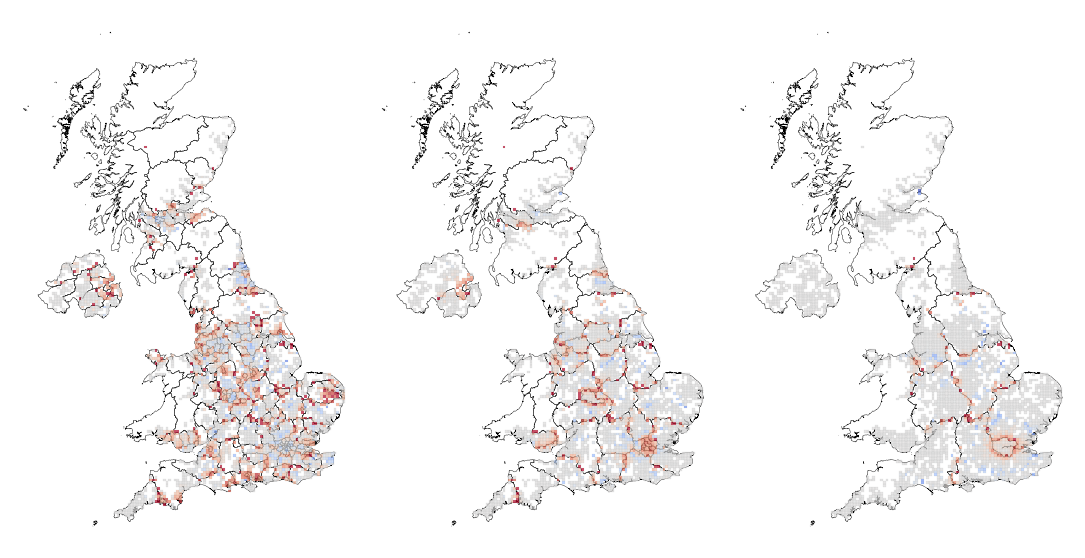

In [39]:
# Plot all quadkeys
fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(wspace=-0.1)
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

tile_width = 0.1
map_width = 0.4
tile_alpha = 0.7

gdf_NUTS3.plot(linewidth=map_width, ax=ax1, facecolor = 'none')
gdf.plot('diff_fine',alpha = tile_alpha, linewidth = tile_width,ax=ax1, cmap='coolwarm',vmin=-1,vmax=1,edgecolor='grey')
ax1.set_axis_off()
#ax1.set(title='MS0 vs. NUTS3')

gdf_NUTS2.plot(linewidth=map_width, ax=ax2, facecolor = 'none')
gdf.plot('diff_middle',alpha = tile_alpha, linewidth = tile_width,ax=ax2, cmap='coolwarm',vmin=-1,vmax=1, edgecolor='grey')
ax2.set_axis_off()
#ax2.set(title='MS1 vs NUTS2')

gdf_NUTS1.plot(linewidth=map_width, ax=ax3, facecolor = 'none')
gdf.plot('diff_coarse',alpha = tile_alpha, linewidth = tile_width,ax=ax3, cmap='coolwarm',vmin=-1,vmax=1,
edgecolor='grey')#, legend=True)
ax3.set_axis_off()
#ax3.set(title='MS3 vs NUTS1')

plt.show()

fig.savefig(root_figure+'containment_maps.pdf', dpi=fig.dpi,bbox_inches='tight')


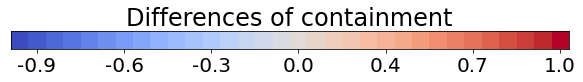

In [40]:
# Plot colourbar
n_steps = 32
fig, ax = plt.subplots(1, figsize=(10, 15))
ax.imshow(np.linspace(-1,1,n_steps).reshape(1,n_steps),cmap='coolwarm')
ax.set(yticks=[],xticks = np.arange(0,n_steps,5)+1,
        xticklabels=np.around(np.asarray(np.linspace(-1,1,n_steps)),1)[np.arange(0,n_steps,5)+1],
        title='Differences of containment')
plt.show()